In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os
import random
from kneed import KneeLocator


In [2]:
def showImages(idxs, image_files=None, images=None):
    plt.figure(figsize=(20, 10))
    if image_files is not None:
        for i, idx in enumerate(idxs):
            img = cv2.imread(image_files[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    elif images is not None:
        for i in range(len(idxs)):
            plt.subplot(1, 5, i + 1)
            plt.imshow(images[i], cmap='gray')  # Hiển thị ảnh xám
            plt.axis('off')
            plt.title(f"Ảnh {i+1}")
    else:
        raise ValueError("Cần cung cấp ít nhất một trong hai tham số: image_files hoặc images")

    plt.show()

1. Tiền xử lý dữ liệu

Số lượng ảnh (thư mục image): 4237
3 ảnh ngẫu nhiên:


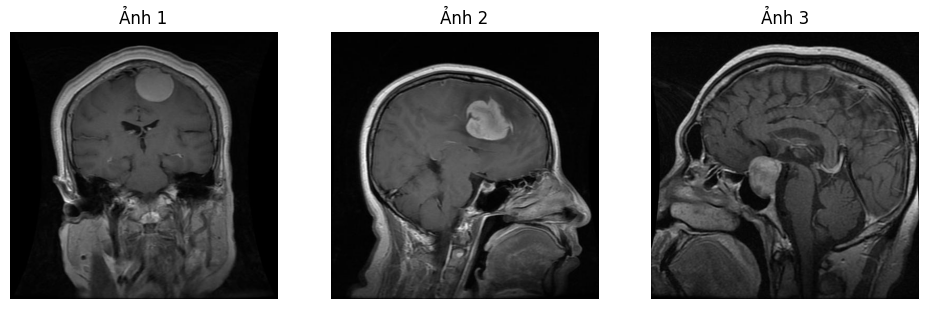

In [13]:
data_dir = r'./Brain Tumor Segmentation Dataset/image'
image_files = []

# Đọc tất cả ảnh gốc vào image_files
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

# Kiểm tra số lượng ảnh
print(f"Số lượng ảnh (thư mục image): {len(image_files)}")

# Hiển thị ngẫu nhiên 3 ảnh mẫu
sample_idxs = random.sample(range(len(image_files)), min(3, len(image_files)))

print("3 ảnh ngẫu nhiên:")
showImages(sample_idxs, image_files=image_files)

3 ảnh xám mẫu:


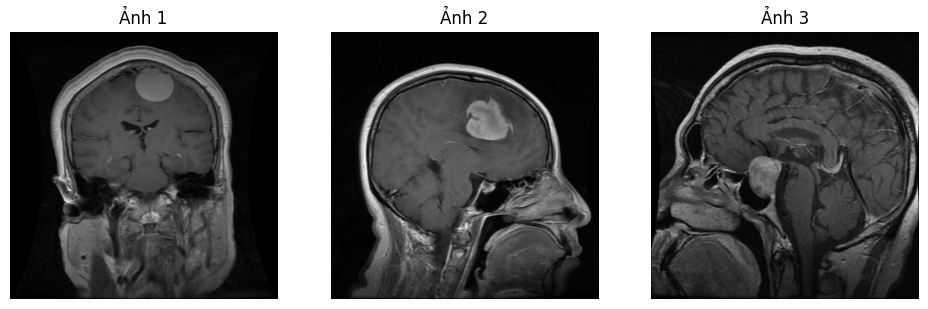

In [14]:
gray_images = []
for idx in sample_idxs:
    gray_img = cv2.imread(image_files[idx], cv2.IMREAD_GRAYSCALE)
    gray_images.append(gray_img)

print("3 ảnh xám mẫu:")
showImages(sample_idxs, images=gray_images)

3 ảnh xám đã resize mẫu:


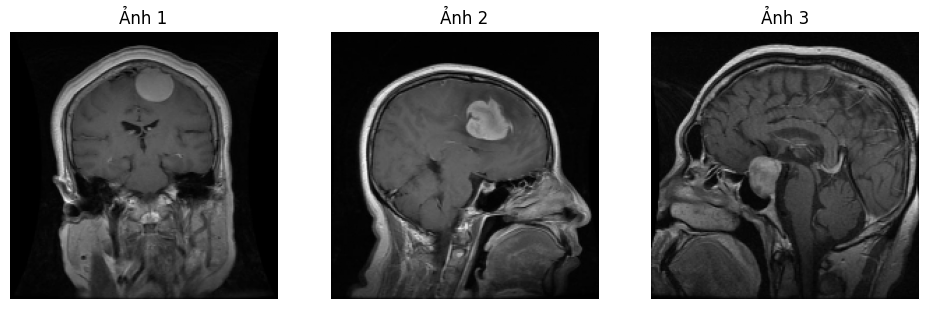

In [15]:
# Resize ảnh về kích thước 192x192
resized_images = []
size = (192, 192)
for img in gray_images:
    resized_img = cv2.resize(img, size, cv2.INTER_AREA)
    resized_images.append(resized_img)

print("3 ảnh xám đã resize mẫu:")
showImages(sample_idxs, images=resized_images)

3 ảnh xám đã cân bằng histogram mẫu:


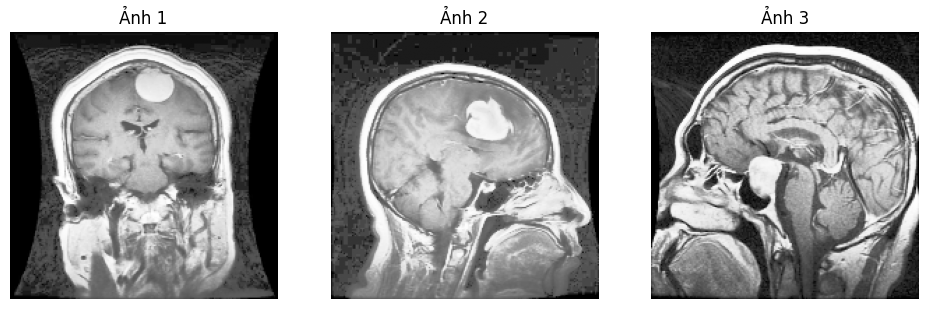

In [16]:
# Cân bằng histogram => Tăng độ tương phản
equalized_images = []
for img in resized_images:
    equalized_img = cv2.equalizeHist(img)  # Cân bằng histogram
    equalized_images.append(equalized_img)

print("3 ảnh xám đã cân bằng histogram mẫu:")
showImages(sample_idxs, images=equalized_images)

3 ảnh xám đã làm mịn mẫu:


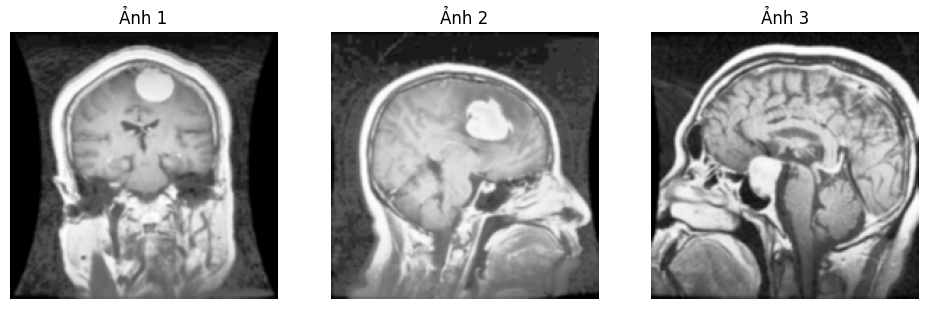

In [17]:
# Làm mịn ảnh
blurred_images = []
for img in equalized_images:
    blurred_img = cv2.GaussianBlur(img, (3, 3), 0)
    blurred_images.append(blurred_img)
print("3 ảnh xám đã làm mịn mẫu:")
showImages(sample_idxs, images=blurred_images)

2. Áp dụng thuật toán DBSCAN

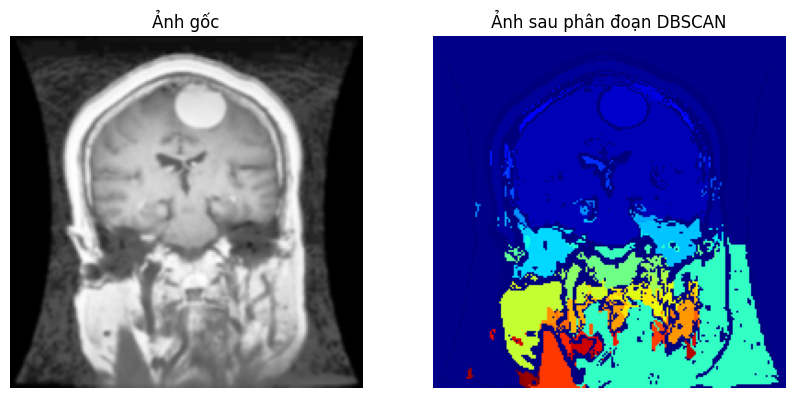

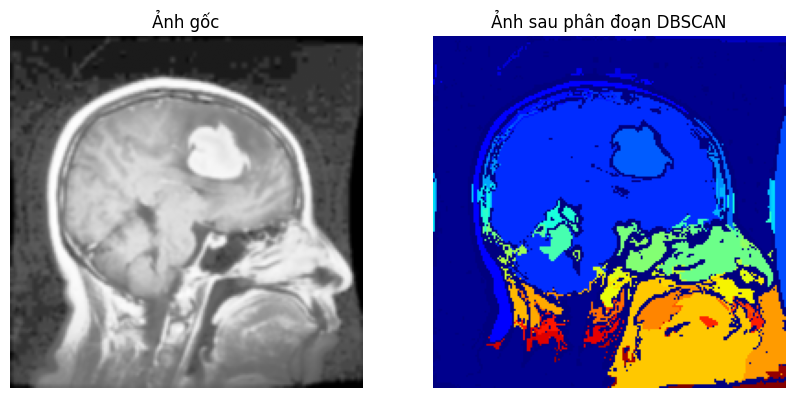

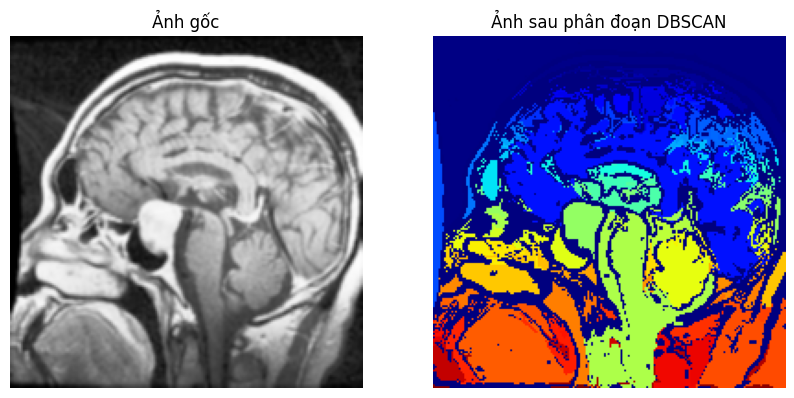

In [18]:
for image in blurred_images:
    h, w = image.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, image.flatten()))
    db = DBSCAN(eps=5, min_samples=10).fit(X)
    labels = db.labels_.reshape(h, w)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)

    plt.subplot(1, 2, 1)
    plt.title("Ảnh gốc")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Ảnh sau phân đoạn DBSCAN
    plt.subplot(1, 2, 2)
    plt.title("Ảnh sau phân đoạn DBSCAN")
    plt.imshow(labels, cmap='jet')  # Sử dụng cmap='jet' để hiển thị các cụm
    plt.axis('off')

    plt.show()



In [29]:
# Tìm eps tối ưu dựa trên k-distance
from sklearn.neighbors import NearestNeighbors
def getEps(X_scaled):
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_scaled)
    distances, _ = neigh.kneighbors(X_scaled)
    distances = np.sort(distances[:, k-1], axis=0)

    # kneedle = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
    # knee_eps = kneedle.knee_y

    n_points = len(distances)
    all_coords = np.arange(n_points)
    first_derivative = np.diff(distances)
    second_derivative = np.diff(first_derivative)
    knee_idx = np.argmax(second_derivative) + 1
    knee_eps = distances[knee_idx]
    
    print(knee_eps)

    # plt.figure(figsize=(10, 5))
    # plt.plot(distances, label='k-distance')
    # plt.axhline(y=knee_eps, color='r', linestyle='--', label=f'Estimated eps = {knee_eps:.3f}')
    # plt.title(f"k-distance Graph (k={k})")
    # plt.xlabel("Points (sorted)")
    # plt.ylabel(f"Distance to {k}th Nearest Neighbor")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return knee_eps

In [36]:
# Áp dụng DBSCAN
# db = DBSCAN(eps=4, min_samples=30)
results = []

for _, image in enumerate(blurred_images):
    h, w = image.shape
    X = np.column_stack((np.indices((h, w)).reshape(2, -1).T, image.flatten())) # tạo mảng (h*w, 3)
    X_scaled = StandardScaler().fit_transform(X)
    eps = getEps(X_scaled)
    clusters = DBSCAN(eps=eps, min_samples=180).fit_predict(X_scaled)
    
    clusterd_image = clusters.reshape(h, w)
    results.append([clusters, clusterd_image])

0.28404224636821146
0.26021177930533695
0.293183589288746


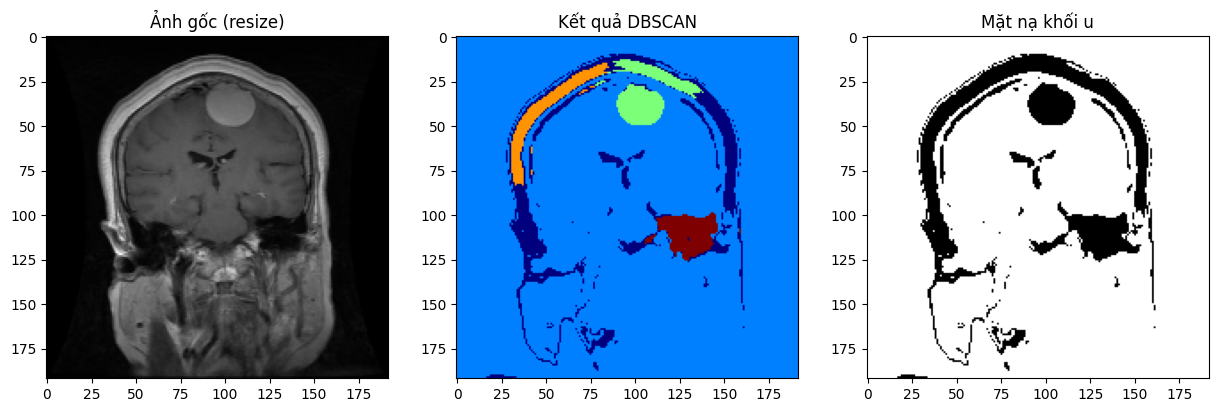

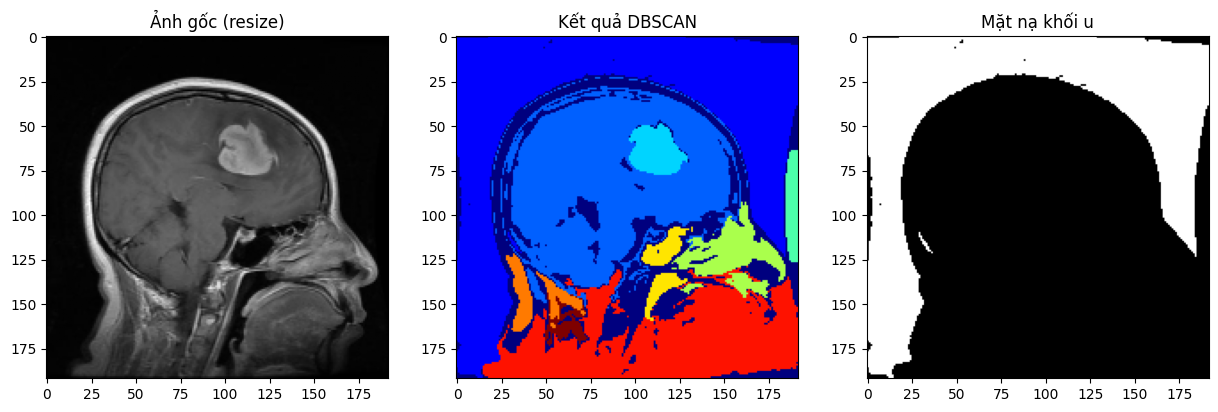

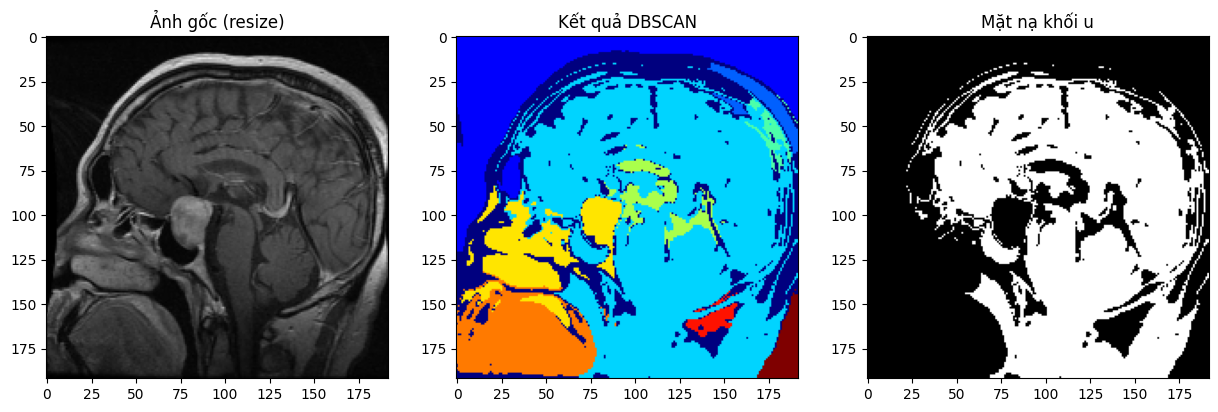

In [40]:
# Hậu xử lý
for i, res in enumerate(results):
    unique_labels, counts = np.unique(res[0][res[0] != -1], return_counts=True)
    if len(unique_labels) > 0:
        tumor_label = unique_labels[np.argmax(counts)]  # Cụm lớn nhất
        tumor_mask = (res[1] == tumor_label).astype(np.uint8) * 255
    else:
        tumor_mask = np.zeros_like(res[1], dtype=np.uint8)

    # Trực quan hóa
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(resized_images[i], cmap='gray')
    plt.title("Ảnh gốc (resize)")
    plt.subplot(1, 3, 2)
    plt.imshow(res[1], cmap='jet')
    plt.title("Kết quả DBSCAN")
    plt.subplot(1, 3, 3)
    plt.imshow(tumor_mask, cmap='gray')
    plt.title("Mặt nạ khối u")
    plt.show()